In [1]:
import os
import pandas as pd
movie_filename = 'movies.csv'
ratings_filename = 'ratings.csv'
path = '/content/drive/MyDrive/input/ml-small/'
df_movies = pd.read_csv(path + movie_filename, usecols=['movieId', 'title'],
                        dtype={'movidId': 'int32', 'title': 'str'})
df_ratings = pd.read_csv(path + ratings_filename, usecols=['movieId', 'userId', 'rating'],
                        dtype={'movidId': 'int32', 'userId': 'int32', 'rating': 'float32'})

# rating을 movie feature 처럼 만들기

In [5]:
from scipy.sparse import csr_matrix
# pivot ratings into movie features
df_movie_features = df_ratings.pivot(
    index = 'movieId',
    columns = 'userId',
    values = 'rating'
).fillna(0)
mat_movie_features = csr_matrix(df_movie_features.values)

print(df_movie_features.head())
print(df_movies.shape)
df_ratings.head()

userId   1    2    3    4    5    6    7    ...  604  605  606  607  608  609  610
movieId                                     ...                                   
1        4.0  0.0  0.0  0.0  4.0  0.0  4.5  ...  3.0  4.0  2.5  4.0  2.5  3.0  5.0
2        0.0  0.0  0.0  0.0  0.0  4.0  0.0  ...  5.0  3.5  0.0  0.0  2.0  0.0  0.0
3        4.0  0.0  0.0  0.0  0.0  5.0  0.0  ...  0.0  0.0  0.0  0.0  2.0  0.0  0.0
4        0.0  0.0  0.0  0.0  0.0  3.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5        0.0  0.0  0.0  0.0  0.0  5.0  0.0  ...  3.0  0.0  0.0  0.0  0.0  0.0  0.0

[5 rows x 610 columns]
(9742, 2)


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


# 유사도 구하기
## KNN 사용하기

In [6]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print(f'There are {num_users} unique users and {num_items} unique movies in this data set')

There are 610 unique users and 9724 unique movies in this data set


## 어떤지 보기

In [7]:
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [8]:
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]

df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True
).sort_index()
df_ratings_cnt

,count
0.0,5830804
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


- 0이 압도적으로 많음
## Normalize

In [11]:
# log 변환을 통해 그래프 해석 쉽게
import numpy as np
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,5830804,15.578665
0.5,1370,7.222566
1.0,2811,7.941296
1.5,1791,7.490529
2.0,7551,8.929435
2.5,5550,8.621553
3.0,20047,9.905835
3.5,13136,9.483112
4.0,26818,10.196829
4.5,8551,9.053804


## 각 점수별로 보기

,count
movieId,
1,215
2,110
3,52
4,7
5,49


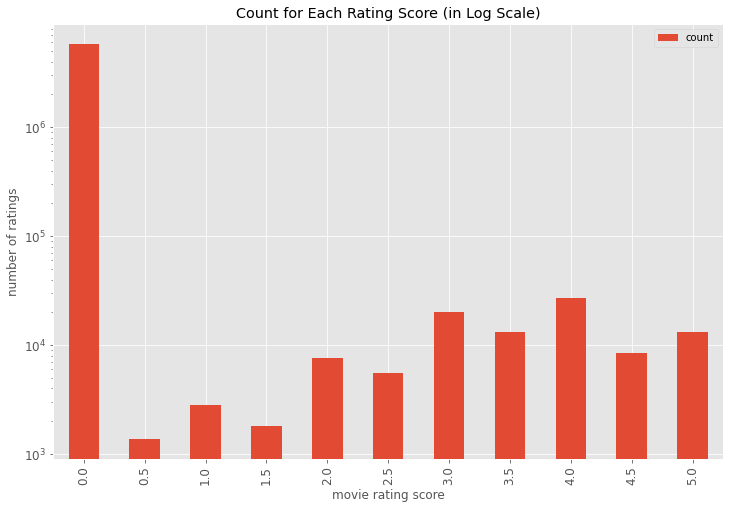

In [16]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

get_ipython().run_line_magic('matplotlib', 'inline')
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x = 'rating score',
    y = 'count',
    kind = 'bar',
    figsize=(12, 8),
    title = 'Count for Each Rating Score (in Log Scale)',
    logy = True,
    fontsize=12,
)
ax.set_xlabel('movie rating score')
ax.set_ylabel('number of ratings')

# 평가 빈도
# 각 영화 리뷰 수
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

## 50개이상 평가된 movie만 필터

In [18]:
popularity_thres = 50

popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (100836, 3)
shape of ratings data after dropping unpopular movies:  (41360, 3)


## 각 유저별로 Rating이 몇 개씩 있는지 확인해보기

In [19]:
df_user_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_user_cnt.head()

,count
userId,
1,117
2,15
3,6
4,84
5,34


## rating이 50개 이상이고 유효한 유저들로만 필터걸기

In [21]:
ratings_thres = 50
active_users = list(set(df_user_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (100836, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (32999, 3)


# Movie-User Matrix

In [22]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)

# map movie titles to images
movie_to_idx = {
    movie: i for i, movie in
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}

# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

# KNN 모델 만들기

In [24]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

# 시청항목과 추천 항목 출력 함수 정의

In [25]:
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz -q

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [27]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio

    Parameters
    ----------------
    mapper: dict, map movie title name to index of the movie in data
    fav_movie: str, name of user input movie

    verbose: bool, pring log if True
    
    Return
    ----------------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))

    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('No match found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format(x[0] for x in match_tuple))
    return match_tuple[0][1]

def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommedations based on user's input movie

    Parameters
    ----------------
    model_knn: sklearn model, knn model
    data: movie-user matrix
    mapper: dict, map movie title name to index of the movie in data
    fav_movie: str, name of user input movie
    n_recommendations: int, top n recommendations
    
    Return
    ----------------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)

    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)

    raw_recommends = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())),
                            key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}

    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))



# 직접 예측

In [28]:
my_favorite = 'Iron Man'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10
)

You have input movie: Iron Man
Found possible matches in our database: <generator object fuzzy_matching.<locals>.<genexpr> at 0x7f65101f8c50>

Recommendation system start to make inference
......

Recommendations for Iron Man:
1: Batman Begins (2005), with distance of 0.3474416136741638
2: Sherlock Holmes (2009), with distance of 0.34635400772094727
3: Kung Fu Panda (2008), with distance of 0.3432350754737854
4: Inception (2010), with distance of 0.3307400345802307
5: District 9 (2009), with distance of 0.31877219676971436
6: Up (2009), with distance of 0.31706738471984863
7: WALL·E (2008), with distance of 0.27033132314682007
8: Avengers, The (2012), with distance of 0.26102906465530396
9: Avatar (2009), with distance of 0.25990235805511475
10: Dark Knight, The (2008), with distance of 0.24018973112106323
